# IPCC AR6 Interactive Atlas Datalab

***

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Projected climate change signals and uncertainty under global warming levels

**E. Cimadevilla** and **M. Iturbide** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook is an **example of the calculation and visualization of the IPCC-WGI AR6 uncertainty methods (simple and advanced) for projected delta changes**. Please refer to the **AR6 WGI Cross-Chapter Box Atlas 1** ([Gutiérrez et al., 2021](https://www.ipcc.ch/report/ar6/wg1/chapter/atlas/)) for more information. We also **introduce the Global Warming Level dimension for the analysis of the climate change signal**.

See also `hatching-uncertainty_R.ipynb` at the [IPCC-WGI/Atlas GitHub repository](https://github.com/IPCC-WG1/Atlas/tree/main/notebooks) (also available in this hub: `shared/repositories/IPCC-WGI-Atlas/notebooks`).

Open the **`Getting_started.ipynb`** for a **quick introduction to the *climate4R* framework**, the bundle of R packages used in this notebook.

This notebook works with the data available in this Hub, this is the dataset underlying [**the IPCC-WGI AR6 Interactive Atlas**](https://interactive-atlas.ipcc.ch/), originally published at [**DIGITAL.CSIC**](https://digital.csic.es/handle/10261/280324) for the long-term archival, and also available through the Copernicus Data Store (**CDS**). Open the **`Getting_started.ipynb`** for a **quick description of the available data**.

### Contents in this notebook
1) Libraries
2) The Global Warming Level analysis dimension
3) Data loading for the different GWLs
4) Data loading for the historical reference
5) Uncertainty calculation and representation
6) Application of a land-sea mask
7) Generate regionalized information
***

Before we start, or at any stage of the notebook, we can customize the plotting area within this notebook as follows:

***

### 1. Libraries

The core ***climate4R*** libraries that allow for **data loading, transformation** (e.g. spatio-temporal aggregations), and **visualization** are `loadeR`, `transformeR` and `visualizeR`. In this example notebook we will also use the `geoprocessoR` package to perform spatial operations.

We will also use other useful libraries; the plotting library `lattice`, `RColorBrewer` for selecting color palettes, and the `magrittr` library for piping operations (through `%>%`).

In [1]:
import re
import math

import xarray
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import requests

### 2. The Global Warming Level analysis dimension

Instead of calculating climate change anomalies for a fixed period, we will calculate the anomaly for a given level of global warming (GWL). To do so, we need the information on the **time windows where the global surface temperature reaches the different levels of warming**. This information is available at the [IPCC-WGI/Atlas GitHub repository](https://github.com/IPCC-WG1/Atlas/tree/main/notebooks). As this Hub contains a clone of this repository in the **`shared/repositories` folder**, we can directly point to the file containing the needed information as follows:

In [2]:
url = "https://github.com/SantanderMetGroup/ATLAS/raw/refs/heads/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv"
gwls_file = url.split("/")[-1]
with open(gwls_file, "w") as f:
    response = requests.get(url)
    response.raise_for_status()
    f.write(response.text)
gwls = pd.read_csv(gwls_file)

In [3]:
gwls.head()

model_run  1.5_ssp126  2_ssp126  3_ssp126  4_ssp126  \
0     ACCESS-CM2_r1i1p1f1      2027.0    2042.0       NaN       NaN   
1  ACCESS-ESM1-5_r1i1p1f1      2030.0    2072.0       NaN       NaN   
2  AWI-CM-1-1-MR_r1i1p1f1      2022.0    2050.0       NaN       NaN   
3    BCC-CSM2-MR_r1i1p1f1      2041.0       NaN       NaN       NaN   
4    CAMS-CSM1-0_r2i1p1f1         NaN       NaN       NaN       NaN   

   1.5_ssp245  2_ssp245  3_ssp245  4_ssp245  1.5_ssp370  2_ssp370  3_ssp370  \
0        2028      2040    2070.0       NaN        2027      2039    2062.0   
1        2029      2045       NaN       NaN        2033      2048    2069.0   
2        2020      2039       NaN       NaN        2021      2037    2064.0   
3        2035      2057       NaN       NaN        2032      2046    2074.0   
4        2055      2088       NaN       NaN        2046      2065       NaN   

   4_ssp370  1.5_ssp585  2_ssp585  3_ssp585  4_ssp585  
0    2082.0        2025      2038      2055    2071.0  
1       NaN        2027      2039      2060    2078.0  
2       NaN        2019      2036      2059    2079.0  
3       NaN        2031      2043      2065       NaN  
4       NaN        2047      2064      2088       NaN

Note that we have pointed to the **`CMIP6_Atlas_WarmingLevels.csv file`**, as we are going to work with CMIP6 data. In this example, we will focus on the **+3ºC GWL**. We will consider the ssp585 scenario, however, any other scenario can be considered, as the anomalies do not vary significantly across scenarios when the GWL dimension is analyzed.

In [4]:
gwls3 = gwls[["model_run", "3_ssp585"]]
gwls3.head()

model_run  3_ssp585
0     ACCESS-CM2_r1i1p1f1      2055
1  ACCESS-ESM1-5_r1i1p1f1      2060
2  AWI-CM-1-1-MR_r1i1p1f1      2059
3    BCC-CSM2-MR_r1i1p1f1      2065
4    CAMS-CSM1-0_r2i1p1f1      2088

Object `gwl3` is a data frame containing the **central year in a time window of 20 years where the +3ºC GWL is reached for each model** (Find more information in the IPCC-WGI/Atlas repository). 

### 3. Data loading for the different GWLs

In [5]:
df = pd.read_csv("../../data_inventory.csv")
subset = df.query('type == "opendap" & variable == "pr" & project == "CMIP6" & experiment == "ssp585" & frequency == "mon"')
location = subset["location"].iloc[0]
location

'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/pr_CMIP6_ssp585_mon_201501-210012.nc'

In [6]:
cmip6_ssp585 = xarray.open_dataset(location)
cmip6_ssp585["member"] = cmip6_ssp585["member"].astype(str)  # due to OPeNDAP reading as bytes
cmip6_ssp585["member"] = [re.sub(r"[^_]+_", "", x, count=1) for x in cmip6_ssp585["member"].values]  # due to different values

# common members
members = [x for x in cmip6_ssp585["member"].values if x in gwls["model_run"].values]
gwls3_ssp585 = gwls3[gwls3["model_run"].isin(members)]
cmip6_ssp585 = cmip6_ssp585.sel(
    member=members,
    lat=slice(35.5, 55.5),
    lon=slice(-9.5, 10.5),
    time=cmip6_ssp585.time.dt.month.isin([12,1,2]))

cmip6_ssp585

<xarray.Dataset>
Dimensions:    (member: 33, time: 258, lat: 21, lon: 21, bnds: 2)
Coordinates:
  * member     (member) <U24 'ACCESS-CM2_r1i1p1f1' ... 'UKESM1-0-LL_r1i1p1f2'
  * time       (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2100-12-01
  * lat        (lat) float64 35.5 36.5 37.5 38.5 39.5 ... 52.5 53.5 54.5 55.5
  * lon        (lon) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 6.5 7.5 8.5 9.5 10.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    crs        int32 ...
    pr         (member, time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.9 ACDD-1.3
    summary:                   IPCC-WGI AR6 Interactive Atlas dataset: Monthl...
    keywords:                  CMIP5, CMIP6, CORDEX, IPCC, Interactive Atlas
    institution:               Instituto de Fisica de Cantabria (IFCA, CSIC-U...
    license:                   CC-BY 4.0, https://creativecommons.org/license...
    references:                https://doi.org/10.1017/9781009157896.021 http...
    standard_name_vocabulary:  CF Standard Name Table (Version 79, 2022-03-19)
    experiment_id:             ssp585
    source:                    CMIP6
    frequency:                 mon
    variable_id:               pr

In [7]:
cmip6_ssp585 = xarray.concat(
    [cmip6_ssp585.sel(
        member=model_run,
        time=slice(f"{year-10}1201", f"{year+10}0201"))
     for model_run, year in gwls3_ssp585.values
     if year != 9999],
    "member")

cmip6_ssp585

<xarray.Dataset>
Dimensions:    (time: 204, lat: 21, lon: 21, member: 33, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2030-12-01 2031-01-01 ... 2098-02-01
  * lat        (lat) float64 35.5 36.5 37.5 38.5 39.5 ... 52.5 53.5 54.5 55.5
  * lon        (lon) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 6.5 7.5 8.5 9.5 10.5
  * member     (member) <U24 'ACCESS-CM2_r1i1p1f1' ... 'UKESM1-0-LL_r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (member, time, bnds) datetime64[ns] NaT NaT NaT ... NaT NaT NaT
    lat_bnds   (member, lat, bnds) float64 35.0 36.0 36.0 ... 55.0 55.0 56.0
    lon_bnds   (member, lon, bnds) float64 -10.0 -9.0 -9.0 ... 10.0 10.0 11.0
    crs        (member) int32 -2147483647 -2147483647 ... -2147483647
    pr         (member, time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    Conventions:               CF-1.9 ACDD-1.3
    summary:                   IPCC-WGI AR6 Interactive Atlas dataset: Monthl...
    keywords:                  CMIP5, CMIP6, CORDEX, IPCC, Interactive Atlas
    institution:               Instituto de Fisica de Cantabria (IFCA, CSIC-U...
    license:                   CC-BY 4.0, https://creativecommons.org/license...
    references:                https://doi.org/10.1017/9781009157896.021 http...
    standard_name_vocabulary:  CF Standard Name Table (Version 79, 2022-03-19)
    experiment_id:             ssp585
    source:                    CMIP6
    frequency:                 mon
    variable_id:               pr

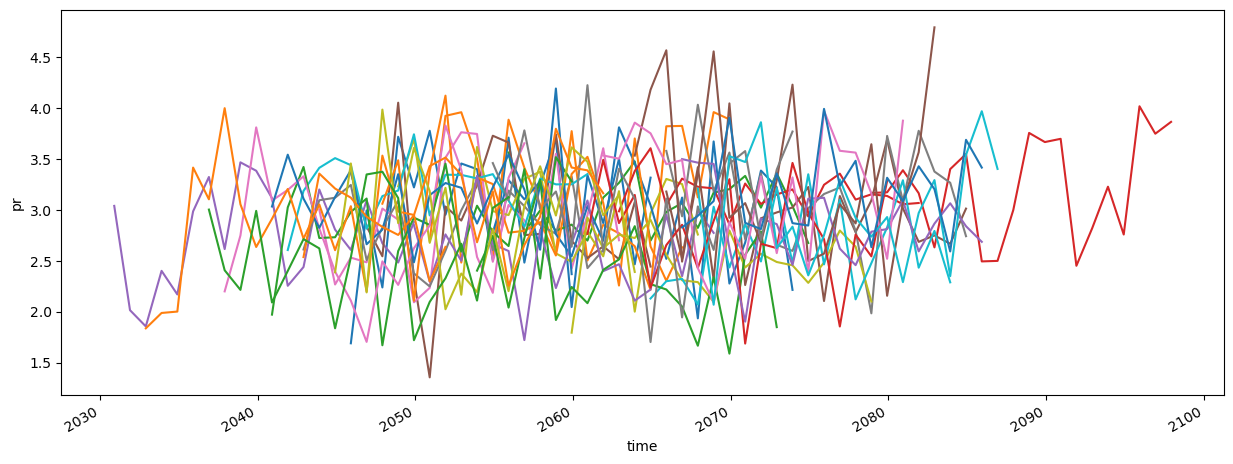

In [8]:
qmean = cmip6_ssp585.mean(["lat", "lon"]).resample(time="QS-DEC").mean()
plot = qmean["pr"].sel(time=qmean["pr"].time.dt.month==12).plot.line(x="time", add_legend=False, figsize=(15, 5))

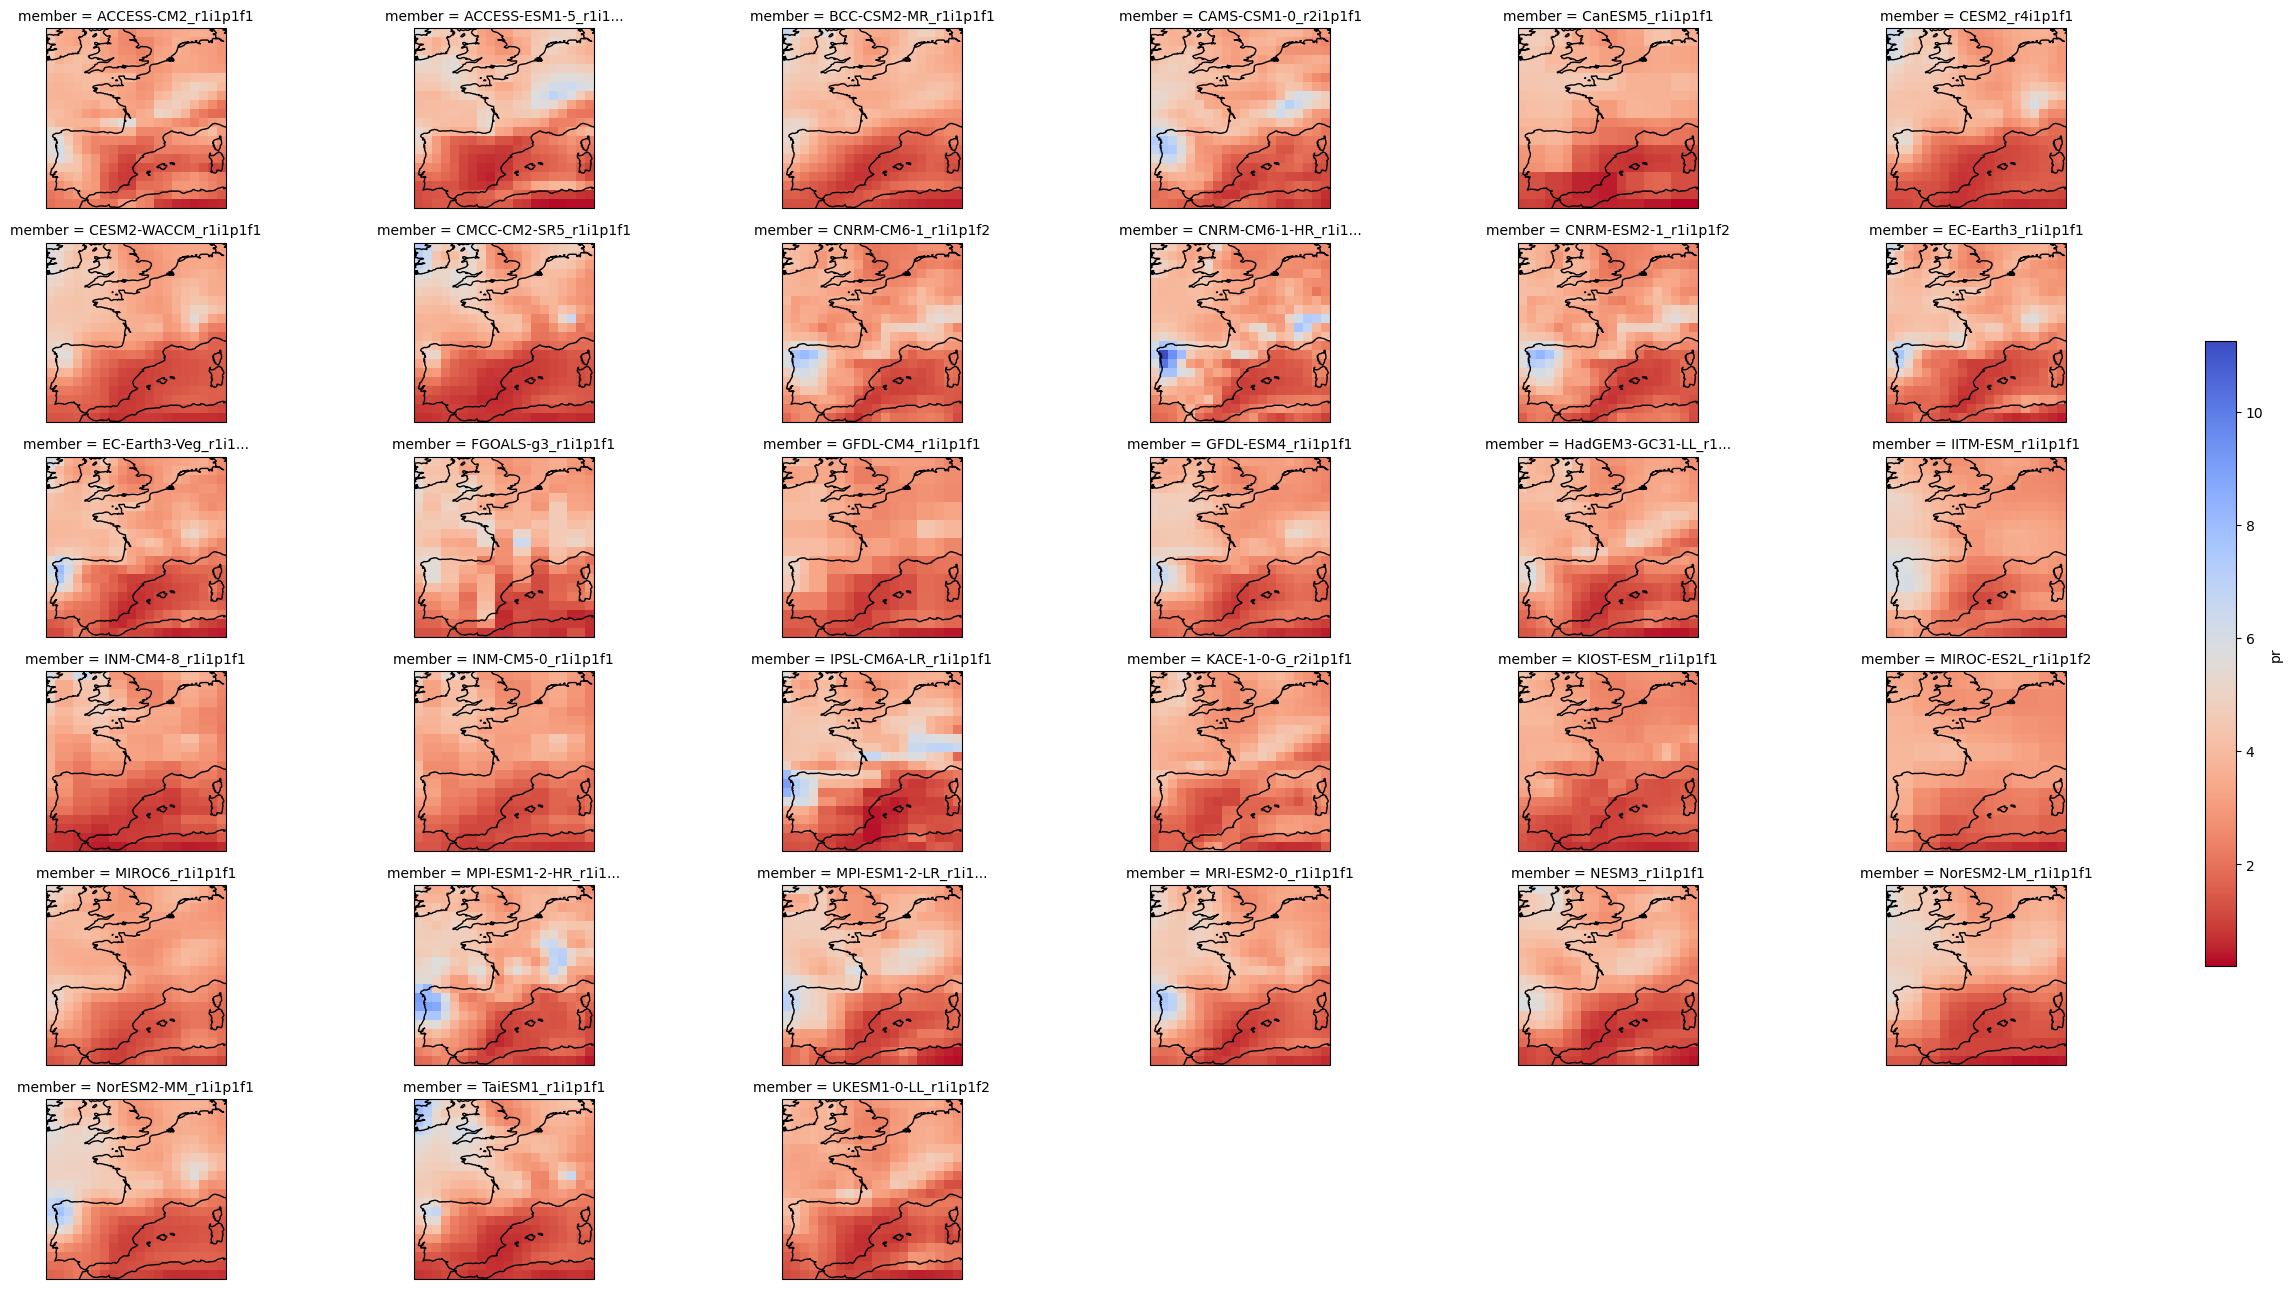

In [9]:
plot = cmip6_ssp585["pr"].mean("time").plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="coolwarm_r",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-10,10,35,55), ccrs.PlateCarree())

### 4. Data loading for the historical reference

To get the climate change signal, we first need to load data from the historical scenario (pointing to `CMIP6_historical.ncml`). As mentioned above, we are considering the pre-industrial period (object `ref.period`). In this case, the reference period is common to all models, therefore the process becomes simpler; all models are loaded at once into a single grid object and we do not need to set a loop. 

In [10]:
df = pd.read_csv("../../data_inventory.csv")
subset = df.query('type == "opendap" & variable == "pr" & project == "CMIP6" & experiment == "historical" & frequency == "mon"')
location = subset["location"].iloc[0]
location

'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/historical/pr_CMIP6_historical_mon_185001-201412.nc'

In [11]:
cmip6_hist = xarray.open_dataset(location).sel(
    lat=slice(35.5, 55.5),
    lon=slice(-9.5, 10.5),
    time=slice("18501201", "19000201"))
cmip6_hist["member"] = cmip6_hist["member"].astype(str)  # due to OPeNDAP reading as bytes
cmip6_hist["member"] = [re.sub(r"[^_]+_", "", x, count=1) for x in cmip6_hist["member"].values]  # due to different values

# common members
members = [x for x in cmip6_ssp585["member"].values if x in cmip6_hist["member"].values]
cmip6_hist = cmip6_hist.sel(
    member=members,
    time=cmip6_hist.time.dt.month.isin([12,1,2]))

cmip6_hist

<xarray.Dataset>
Dimensions:    (member: 33, time: 150, lat: 21, lon: 21, bnds: 2)
Coordinates:
  * member     (member) <U25 'ACCESS-CM2_r1i1p1f1' ... 'UKESM1-0-LL_r1i1p1f2'
  * time       (time) datetime64[ns] 1850-12-01 1851-01-01 ... 1900-02-01
  * lat        (lat) float64 35.5 36.5 37.5 38.5 39.5 ... 52.5 53.5 54.5 55.5
  * lon        (lon) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 6.5 7.5 8.5 9.5 10.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    crs        int32 ...
    pr         (member, time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.9 ACDD-1.3
    summary:                   IPCC-WGI AR6 Interactive Atlas dataset: Monthl...
    keywords:                  CMIP5, CMIP6, CORDEX, IPCC, Interactive Atlas
    institution:               Instituto de Fisica de Cantabria (IFCA, CSIC-U...
    license:                   CC-BY 4.0, https://creativecommons.org/license...
    references:                https://doi.org/10.1017/9781009157896.021 http...
    standard_name_vocabulary:  CF Standard Name Table (Version 79, 2022-03-19)
    experiment_id:             historical
    source:                    CMIP6
    frequency:                 mon
    variable_id:               pr

It is always a good practice to make sure that the members in both grids are identical:

In [12]:
print(f'Are all members identical? {(cmip6_hist["member"] == cmip6_ssp585["member"]).all().item()}')

Are all members identical? True


Now we can calculate the anomaly by computing the difference between both climatologies:

In [13]:
delta = cmip6_ssp585["pr"].mean("time") - cmip6_hist["pr"].mean("time")

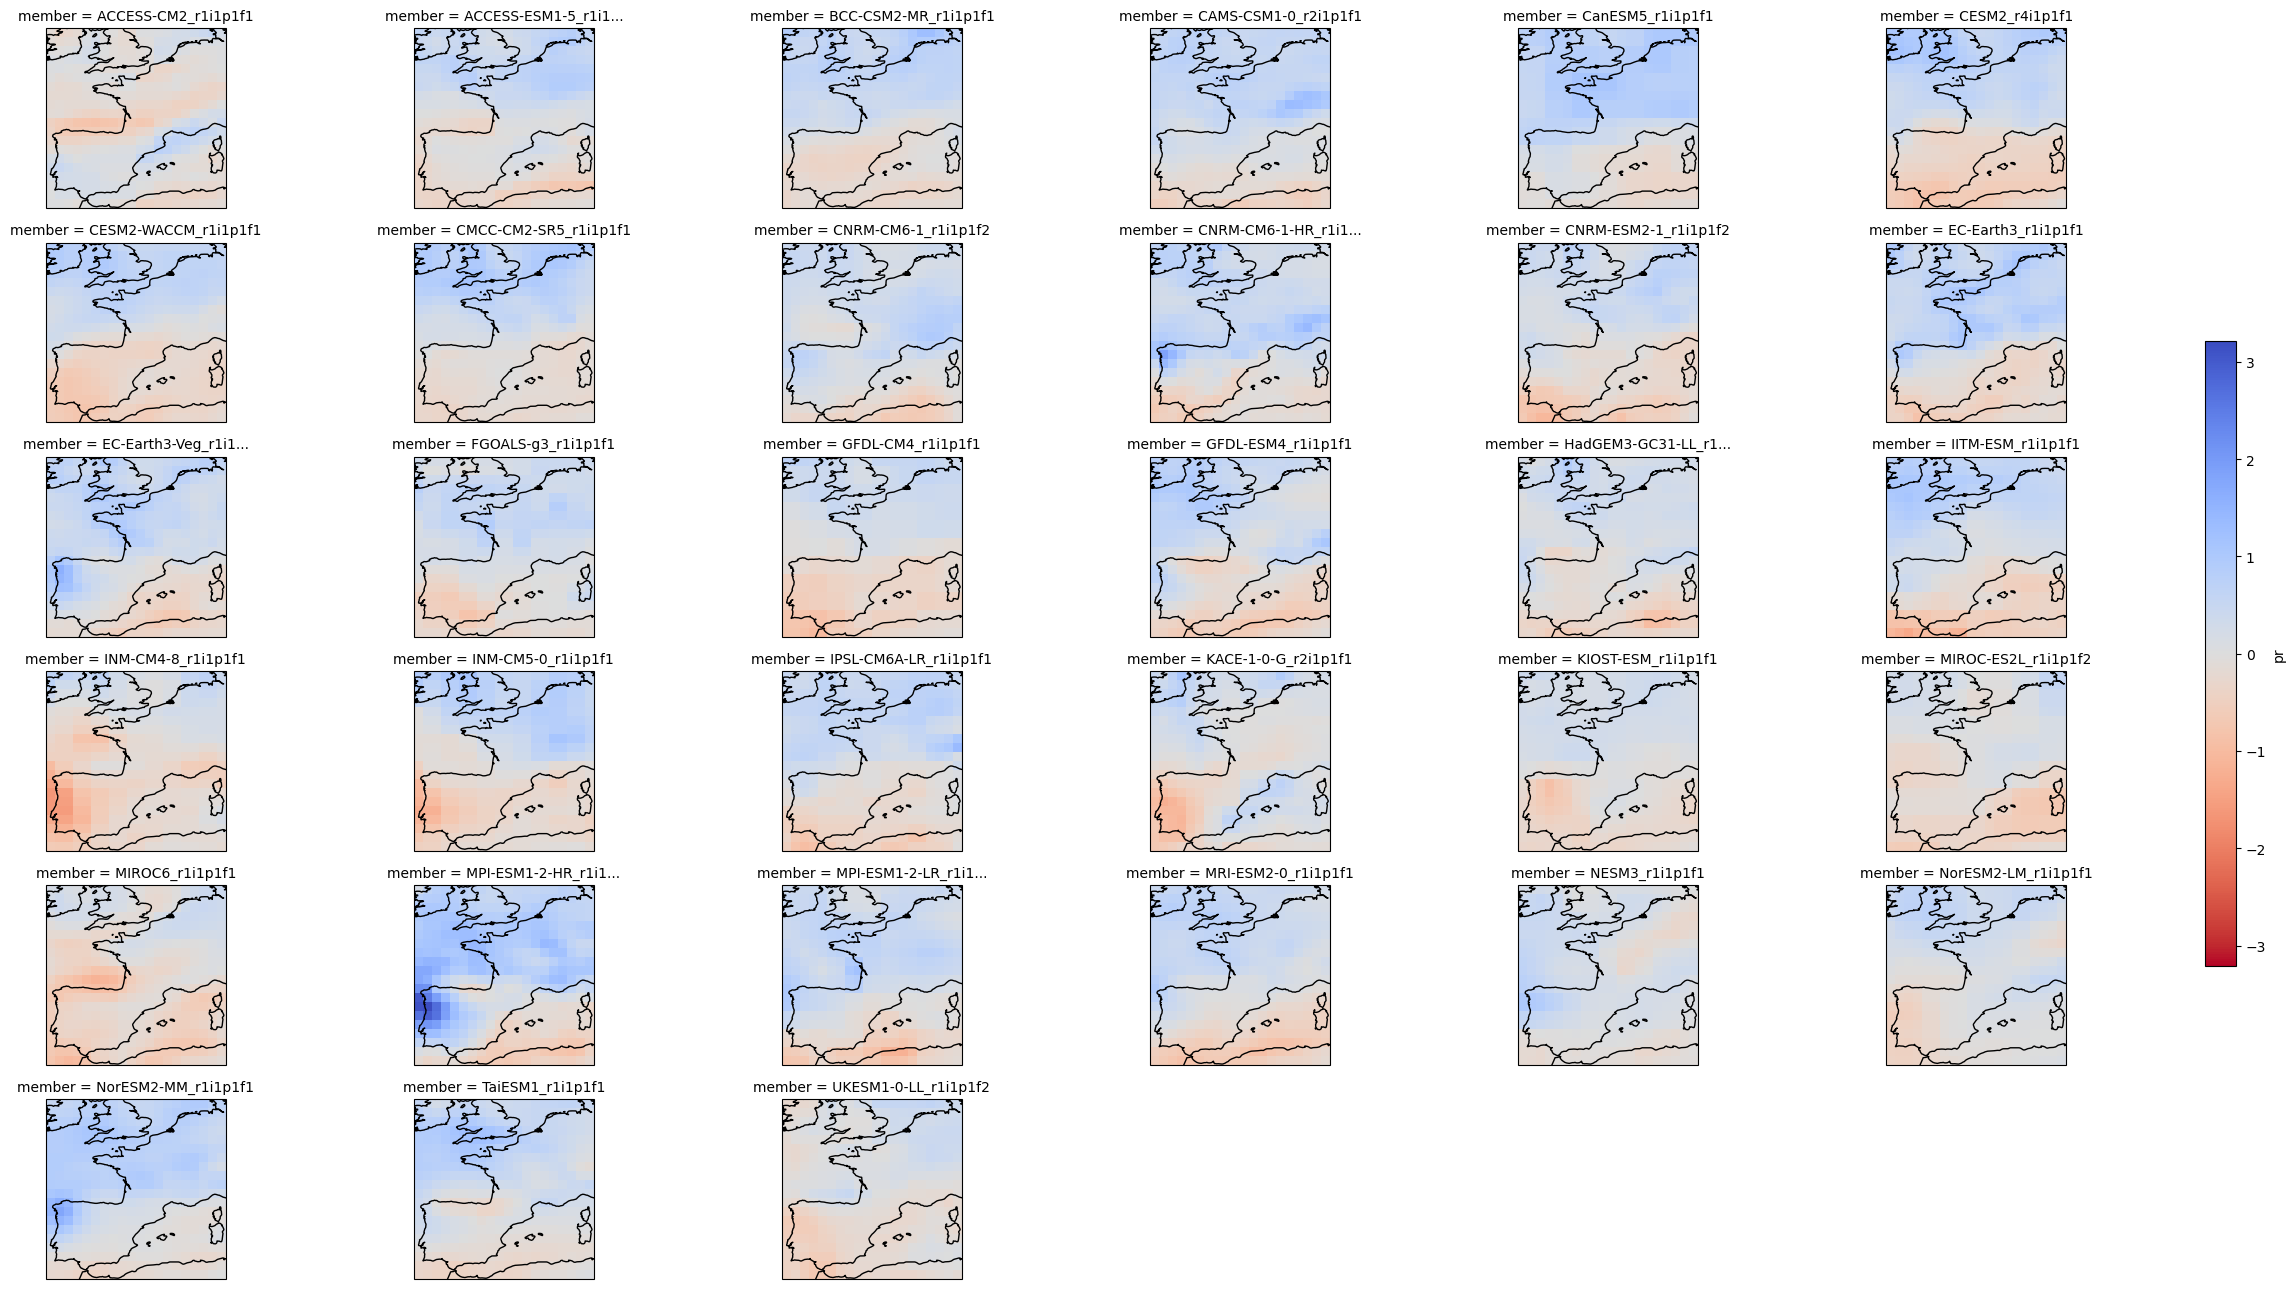

In [14]:
plot = delta.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="coolwarm_r",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-10,10,35,55), ccrs.PlateCarree())

plot.fig.savefig("pr-delta.svg")

We can calculate the relative anomaly the same way:

In [15]:
delta_rel = (delta / cmip6_hist["pr"].mean("time")) * 100

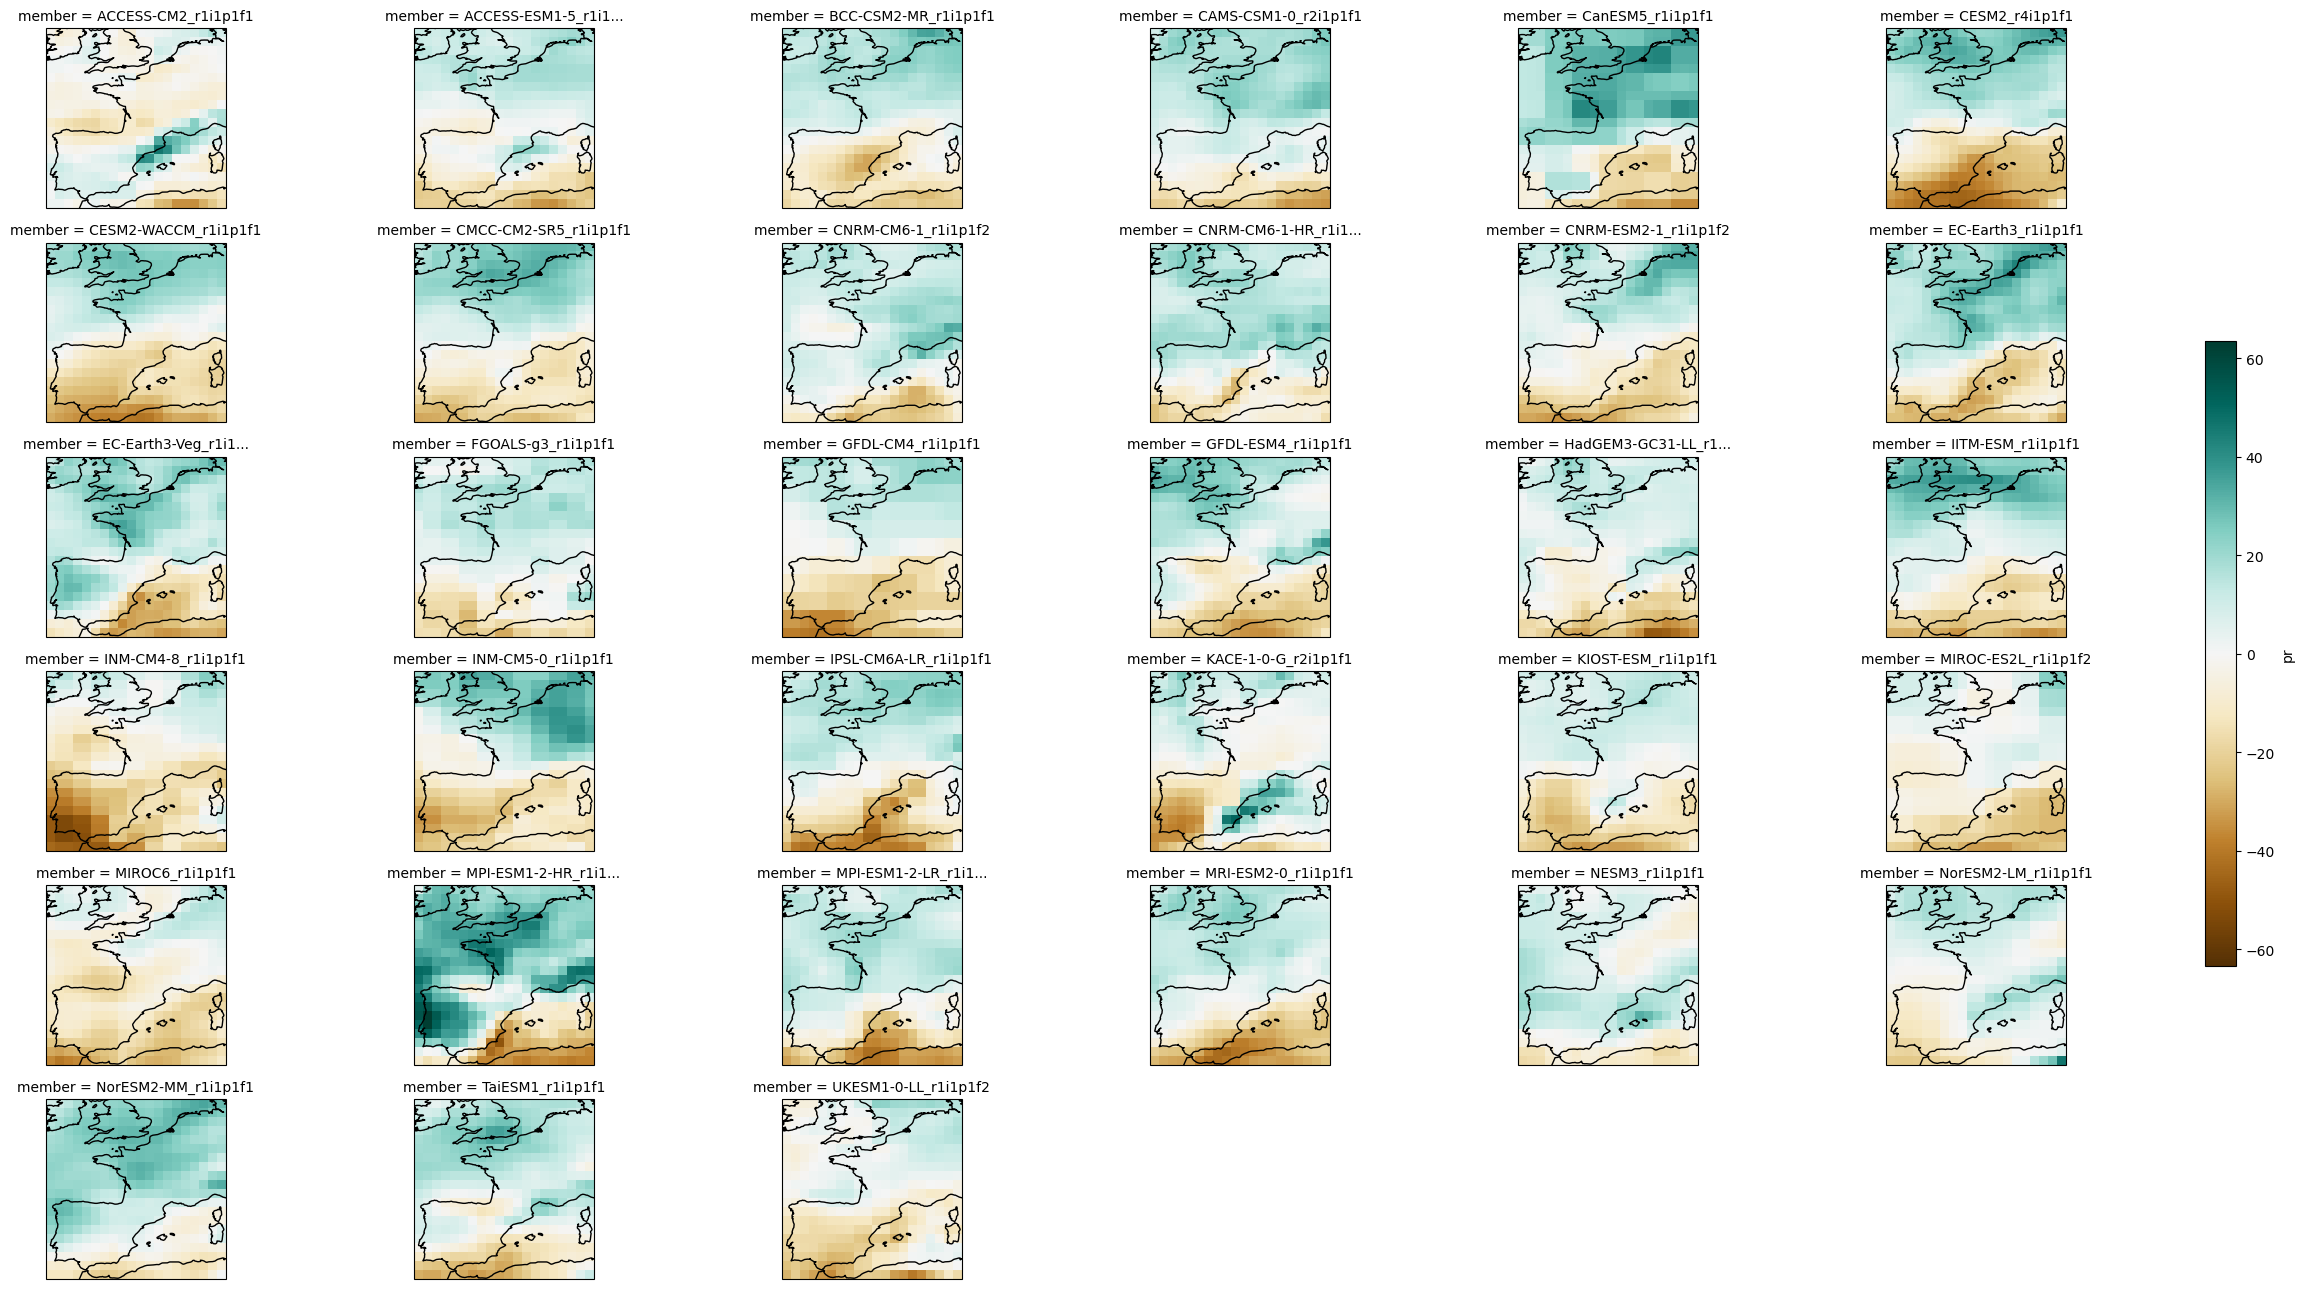

In [16]:
plot = delta_rel.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-10,10,35,55), ccrs.PlateCarree())

To calculate the multi-model mean, use function `aggregateGrid`.

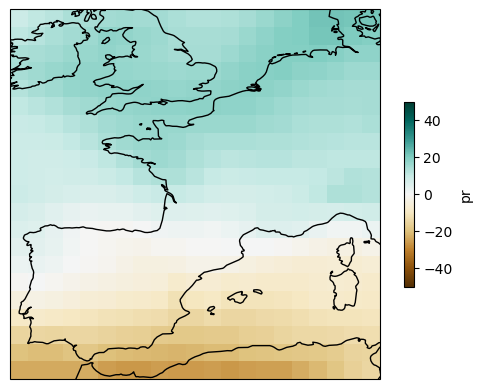

In [17]:
ens_mean = delta_rel.mean("member")

plot = ens_mean.plot(
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

plot.axes.coastlines()

### 5. Uncertainty calculation and representation

*climate4R* implements the "simple" and "advanced" methods for the uncertainty characterization defined in the IPCC Sixth Assessment report. The function to apply is `computeUncertainty`. Please refer to the **AR6 WGI Cross-Chapter Box Atlas 1** ([Gutiérrez et al., 2021](https://www.ipcc.ch/report/ar6/wg1/chapter/atlas/)) for more information.

In [18]:
def model_agreement(da, axis, th = 80):
    nmembers, nlat, nlon = da.shape
    mask = np.array([
        (da[:,i,j] > 0).sum() > int(nmembers * th / 100)
        if da[:,i,j].mean() > 0
        else (da[:,i,j] < 0).sum() > int(nmembers * th / 100)
        for i in range(nlat)
        for j in range(nlon)]).reshape((nlat,nlon))
    
    return mask

def hatching(plot, mask, data):
    rows, cols = mask.shape
    for i in range(rows):
        for j in range(cols):
            lat, lon = data["lat"][i].item(), data["lon"][j].item()
            if mask[i,j]:
                plot.axes.plot([lon-.5,lon+.5],[lat+.5,lat-.5],'-',c="black", linewidth=.5)

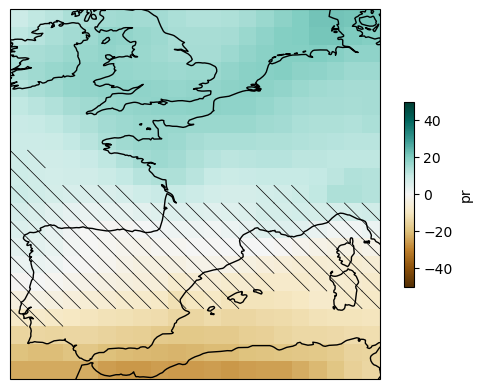

In [19]:
mask_simple = delta.reduce(model_agreement, "member")

plot = ens_mean.plot(
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

hatching(plot, ~mask_simple, ens_mean)

plot.axes.coastlines()

Now we compute the "advanced" method:

In [20]:
def advanced_method(historical, delta):
    vth = historical.reduce(
        lambda da, axis: ((math.sqrt(2) * 1.645 * np.std(da, axis=axis, ddof=1)) / math.sqrt(20)),
        "time")
    anom_abs = np.abs(delta)
    sig = anom_abs - vth
    si = xarray.where(sig > 0, 1, 0)
    uncer3 = delta.reduce(model_agreement, "member", th=80)
    uncer1 = si.reduce(
        lambda da, axis, nmembers, th: (da.sum(axis)/nmembers)*100 > th,
        "member",
        nmembers=si["member"].size,
        th=66)
    uncer2 = si.reduce(
        lambda da, axis, nmembers, th: (da.sum(axis)/nmembers)*100 < th,
        "member",
        nmembers=si["member"].size,
        th=66)
    uncer23 = (uncer2.astype(int) + uncer3.astype(int)) > 0
    uncer_a_aux1 = ((uncer1.astype(int) - 1) * -1).values
    uncer_a_aux2 = ((uncer23.astype(int) - 1) * -1).values
    uncer_a_aux2[uncer_a_aux2 == 1] = 2
    uncer_a_aux = uncer_a_aux1 + uncer_a_aux2
    uncer_a_aux[uncer_a_aux>1] = 2

    return uncer_a_aux

In [21]:
a = cmip6_hist["pr"].resample(time="QS-DEC").mean()
historical = a.sel(time=a.time.dt.month==12)

mask_advanced = advanced_method(historical, delta)

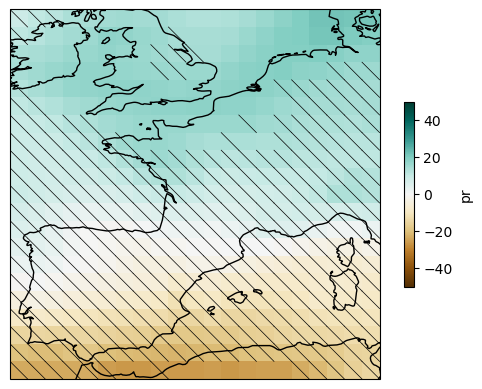

In [22]:
plot = ens_mean.plot(
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

hatching(plot, mask_advanced, ens_mean)

plot.axes.coastlines()

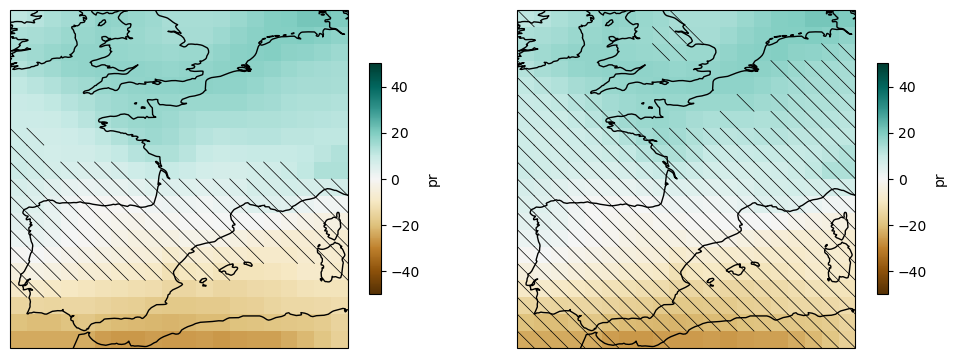

In [23]:
fig, axes = plt.subplots(1,2, figsize=(12,6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

plot_simple = ens_mean.plot(
    ax=axes[0],
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    transform=ccrs.PlateCarree())

plot_advanced = ens_mean.plot(
    ax=axes[1],
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    transform=ccrs.PlateCarree())

hatching(plot_simple, ~mask_simple, ens_mean)
hatching(plot_advanced, mask_advanced, ens_mean)

for ax in axes.flatten():
    ax.coastlines()
    ax.set_extent((-10,10,35,55), ccrs.PlateCarree())

plt.savefig("uncertainty.svg")

### 6. Application of a land-sea mask

The land-sea masks necessary for this dataset are accessible in the IPCC-WGI/Atlas GitHub repository, which is mirrored here. Given that the CMIP6 data within the IPCC-WGI AR6 Interactive Atlas dataset adopts a consistent 1-degree grid, it is essential to reference the 1-degree mask (`land_sea_mask_1degree.nc4`) located in the `shared/repositories` folder. The variable name is "sftlf" in this case.
After loading the mask, we need to apply a threshold to the resulting grid, to make it binary (NA = sea, 1 = land).

In [24]:
url = "https://github.com/SantanderMetGroup/ATLAS/raw/refs/heads/main/reference-grids/land_sea_mask_1degree.nc4"
mask_file = url.split("/")[-1]
with open(mask_file, "wb") as f:
    response = requests.get(url)
    response.raise_for_status()
    f.write(response.content)

In [25]:
with xarray.open_dataset(mask_file) as mask:
    mask_sel = mask.sel(lat=slice(35.5, 55.5), lon=slice(-9.5, 10.5))
    sftlf = (mask_sel["sftlf"] > 0.5).astype(int)

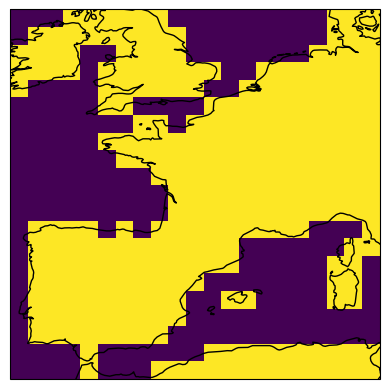

In [26]:
plot = sftlf.plot(
    add_colorbar=False,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())
plot.axes.coastlines()

To apply the mask, you can utilize the `gridArithmetics` function directly.

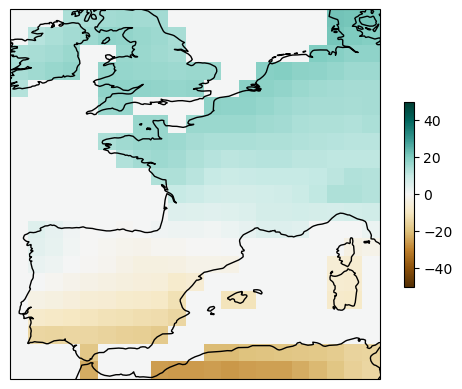

In [27]:
ens_mean_land = ens_mean * sftlf

plot = ens_mean_land.plot(
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())
plot.axes.coastlines()

To apply the same mask to the multi-model grid, a trick can be employed to duplicate the mask for each member in the target grid:

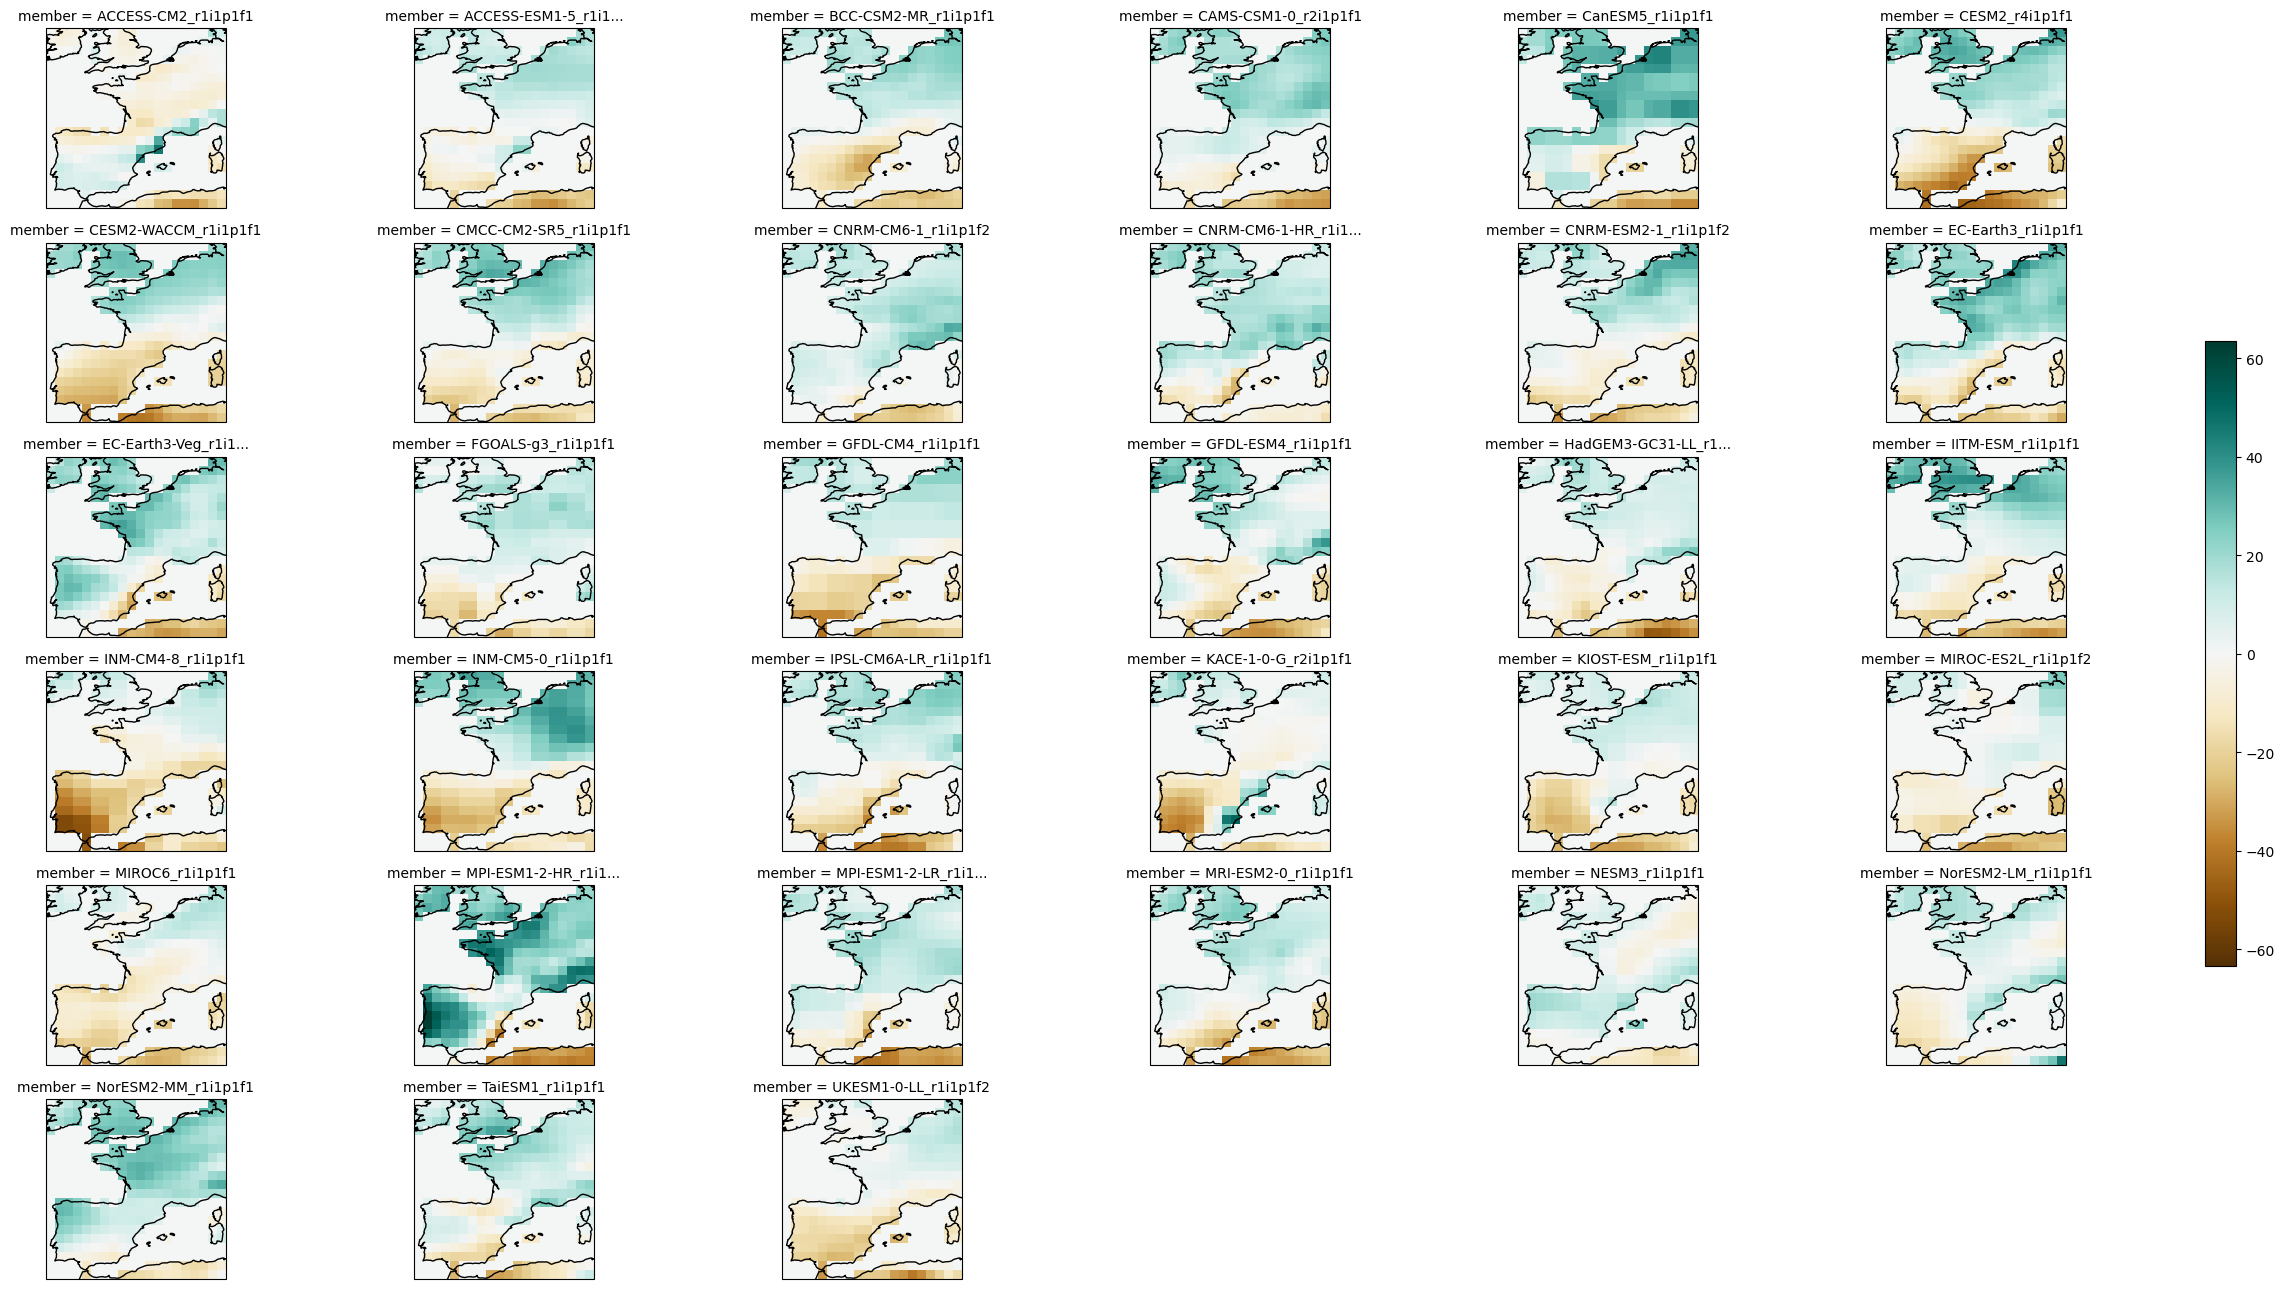

In [28]:
delta_rel_land = delta_rel * sftlf

plot = delta_rel_land.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-10,10,35,55), ccrs.PlateCarree())

### 7. Generate regionalized information

Here is an example of generating regional stripes. First, we aggregate the data yearly using the `aggregateGrid` function and calculate the historical climatology. Then, employing a similar approach to the one mentioned earlier, we duplicate the historical climatology for each time step in the future yearly data to ensure consistent array dimensions. This enables the calculation of year anomalies relative to the historical climatology using the `gridArithmetics` function. 

In [29]:
cmip6_ssp585_y = cmip6_ssp585["pr"].resample(time="QS-DEC").mean()
cmip6_ssp585_y = cmip6_ssp585_y.sel(time=cmip6_ssp585_y["time"].dt.month==12)

cmip6_hist_c = cmip6_hist["pr"].mean(["time"])

year_delta = cmip6_ssp585_y - cmip6_hist_c
year_delta_rel = year_delta / cmip6_hist_c * 100

regional_mean = year_delta_rel.mean(["lat", "lon"])

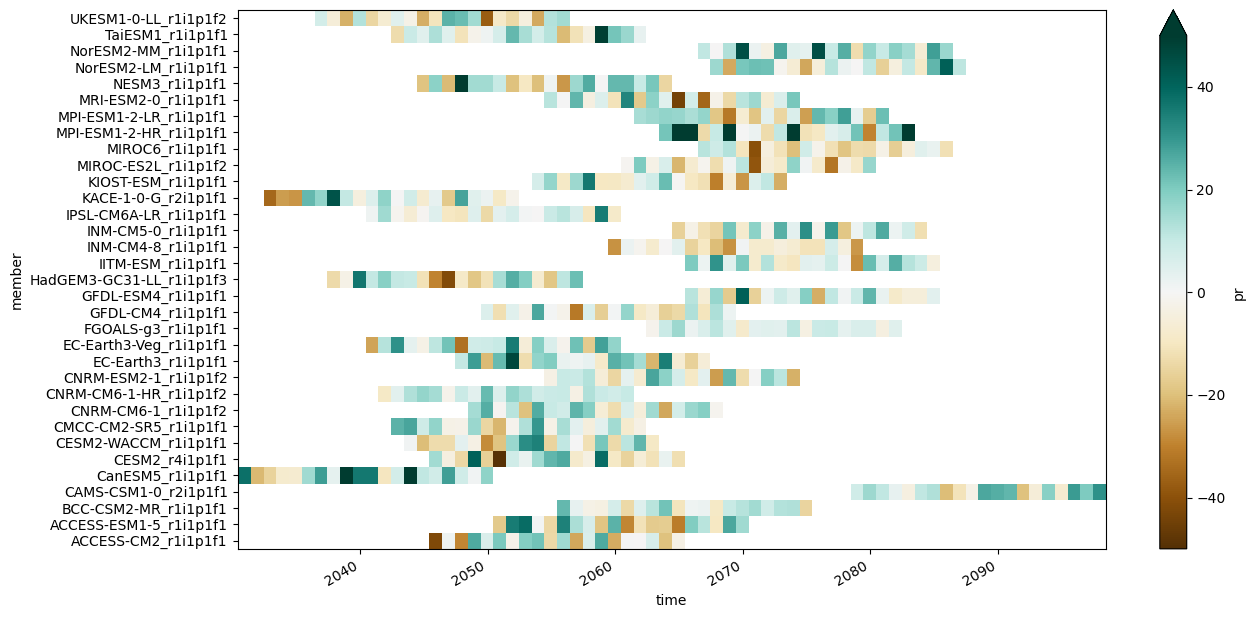

In [30]:
regional_mean.plot.imshow(
    figsize=(14,7),
    add_colorbar=True,
    cmap="BrBG",
    vmin=-50,vmax=50)

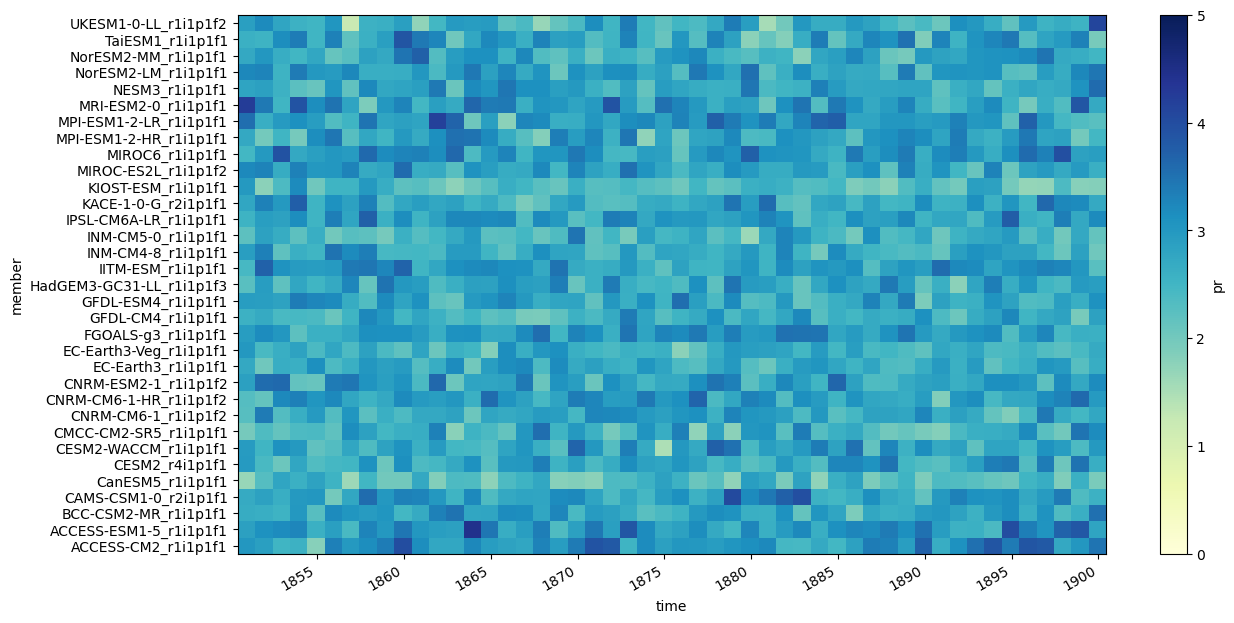

In [31]:
cmip6_hist_y = cmip6_hist["pr"].resample(time="QS-DEC").mean()
cmip6_hist_y = cmip6_hist_y.sel(time=cmip6_hist_y["time"].dt.month==12)

cmip6_hist_y.mean(["lat", "lon"]).plot.imshow(
    figsize=(14,7),
    add_colorbar=True,
    cmap="YlGnBu",
    vmin=0,vmax=5)